In [1]:
%matplotlib inline

import numpy as np
import power_laws
import matplotlib.colors
import seaborn as sns
import pandas as pd
import rubisco_data

from scipy import stats
from sklearn import metrics
from matplotlib import pyplot as plt

In [2]:
# Load the data from Excel, remove data points that are not comparable.
# raw_kin_df is everything in the file, kin_df is the subset with all relevant kinetic data.
raw_kin_df, kin_df = rubisco_data.load_rubisco_data()

# Subset the data in various ways for future use
raw_kin_df, savir_df, nonsavir_df = rubisco_data.filter_data(raw_kin_df)

# Merge multiple measurements of the same organism by taking the median value.
merged_kin_df = rubisco_data.merge_organisms(raw_kin_df)

# Group by RuBisCO form
grouped_form = merged_kin_df.groupby('isoform')

# Markers we use for plotting below.
markers = 'o><^dsphH*'

cnames = ["windows blue", "amber", "greyish brown", "dusty purple", "dusty teal", "dusty red", ]
named_colors = sns.xkcd_palette(cnames)

In [3]:
# Categories used to color enzymes by the physiology of their host organisms. Purpose
# of this is to highlight the steroetyped variation in SC/O. 

# Note: it's challenging to come up with a uniform taxonomy for autotrophs because the
# important physiological characteristics (e.g. C4, CAM, carboxysome CCMs) are polyphyletic.
# The ad-hoc taxonomy in our supplementary file could probably be improved. However, for
# the purposes of this work, we "lump" together some of the groups for which there is
# limited data - groups like heterokonts and haptophytes, which are phylogenetically disparate
# algae for which we have limited Rubisco data. 

group_mapping = {'C3 plants': 'C3 plants',
                 'C3-C4 plants': 'Other Form I',
                 'Cyanobacteria': 'Cyanobacteria',
                 'C4 plants': 'C4 plants',
                 'Gymnosperm': 'Other Form I',
                 'Basal angiosperm': 'Other Form I',
                 'Carnivorous plants': 'Other Form I',
                 'Bryophyte': 'Other Form I',
                 'CAM plants': 'Other Form I',
                 'Green algae': 'Other Form I',
                 'Diatoms': 'Other Form I',
                 'Chromophyte algae': 'Other Form I',
                 'Haptophyte algae': 'Other Form I',
                 'Rhodophyte algae': 'Other Form I',
                 'Macroalgae': 'Other Form I',
                 'Red algae': 'Red algae',
                 'Alphaproteobacteria': 'Other Form I',
                 'Betaproteobacteria': 'Other Form I',
                 'Gammaproteobacteria': 'Other Form I',
                }
color_mapping = {
    'C3-C4 plants': 'very light brown',
    'C4 plants': 'pea soup',
    'C3 plants': 'dusty green',
    'Other plants': 'grey/green',
    'Cyanobacteria': 'dark blue green',
    'Green algae': 'dusty teal',
    'Red algae': 'dusty red',
    'Diatoms': 'gunmetal',
    'Other algae': 'muddy brown',
    'Proteobacterial FI': 'dusty rose',
    'Other Form I': 'grey',
}
fancy_labels = {
    'C3-C4 plants': '$C_3$-$C_4$ plants',
    'C4 plants': '$C_4$ plants',
    'C3 plants': '$C_3$ plants',
}
label2color = dict((fancy_labels.get(k, k), sns.xkcd_rgb[color_mapping.get(k)])
                   for k in color_mapping.keys())

F1_data = merged_kin_df[merged_kin_df.isoform == '1']
F2_data = merged_kin_df[merged_kin_df.isoform == '2']
grouped_taxa = F1_data.set_index('taxonomy').groupby(group_mapping)

# Order of plotting sets order of legend.
plotting_order = ['C3 plants', 'C4 plants', 'Red algae', 'Cyanobacteria', 'Other Form I']
# These groups have enough data for histograms to be plotted.
hist_groups = ['C4 plants', 'C3 plants', 'Cyanobacteria', 'Red algae', ]

In [4]:
# Note: kon_C is the Savir 2010 notation for kcat,C/KC. kon_O is kcat,O/KO. 
# Figure examines the correlations between kcat,O/KO and kcat,C/KC.
# This correlation is very strong. Importantly, we note that this correlation is required
# given the fact that SC/O varies very little. See equations below for logic:
# S = kcat,C/KC / (kcat,O/KO) ~= const
# log(S) = log(kcat,C/KC) - log(kcat,O/KO) ~= const
# log(kcat,C/KC) ~= log(kcat,O/KO) + const
# So roughly constant S implies power law correlation between kcat,C/KC and kcat,O/KO
# with exponent of 1.0

# kon_O vs kon_C
kon_Os = np.log(merged_kin_df.kon_O)
kon_Cs = np.log(merged_kin_df.kon_C)

print('Whole dataset correlation')
r, p = power_laws.log_pearsonr(kon_Os, kon_Cs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(kon_Os, kon_Cs))
print()

fIs = merged_kin_df[merged_kin_df.isoform == '1']
kon_Os = np.log(fIs.kon_O)
kon_Cs = np.log(fIs.kon_C)

# Notice that restricting to FI improves the correlation because FII have very different S
print('FI subset')
r, p = power_laws.log_pearsonr(kon_Os, kon_Cs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(kon_Os, kon_Cs))
print()

kon_Os = np.log(savir_df.kon_O)
kon_Cs = np.log(savir_df.kon_C)

print('Savir correlation')
r, p = power_laws.log_pearsonr(kon_Os, kon_Cs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(kon_Os, kon_Cs))

Whole dataset correlation
Log-scale linear regression R = 0.66, P = 3.2e-24
Spearman rank correlation R = 0.85, P = 1.9e-52

FI subset
Log-scale linear regression R = 0.94, P = 6e-87
Spearman rank correlation R = 0.93, P = 4.9e-80

Savir correlation
Log-scale linear regression R = 0.58, P = 0.02
Spearman rank correlation R = 0.49, P = 0.055


/usr/local/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


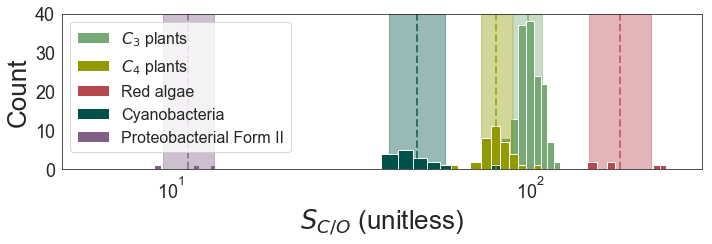

In [5]:
# Plot of SC/O distributions
figure = plt.figure(figsize=(10,3.5))
sns.set_style('white')
plt.xscale('log')

for i, group in enumerate(plotting_order):
    if group.startswith('Other'):
        # skipping 'Other FI' here.
        continue
        
    gdf = grouped_taxa.get_group(group)
    cname = color_mapping[group]
    c = sns.xkcd_rgb[cname]
    
    # Plot geometric mean and std
    mask = gdf.S.notnull()
    masked_S = gdf[mask].S
    gmean_S = stats.gmean(masked_S)
    gstd = np.exp(np.nanstd(np.log(masked_S)))
    plt.axvline(gmean_S, color=c, ls='--', alpha=0.7, lw=2)
    plt.axvspan(gmean_S/gstd, gmean_S*gstd, color=c, alpha=0.4)
    
    # Plot hist above stats. 
    label = fancy_labels.get(group, group)
    plt.hist(gdf.S, color=c, label=label)
    

cname = 'dusty purple'
c = sns.xkcd_rgb[cname]
plt.hist(F2_data.S, color=c, label='Proteobacterial Form II')

mask = F2_data.S.notnull()
masked_S = F2_data[mask].S
gmean_S = stats.gmean(masked_S)
gstd = np.exp(np.nanstd(np.log(masked_S)))
plt.axvline(gmean_S, color=c, ls='--', alpha=0.7, lw=2)
plt.axvspan(gmean_S/gstd, gmean_S*gstd, color=c, alpha=0.4)
    
plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlabel('$S_{C/O}$ (unitless)', fontsize=26)
plt.ylabel('Count', fontsize=26)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlim(5e0, 3e2)
plt.tight_layout()

plt.savefig('fig7/fig7_S_dists.png')
plt.show()

/usr/local/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


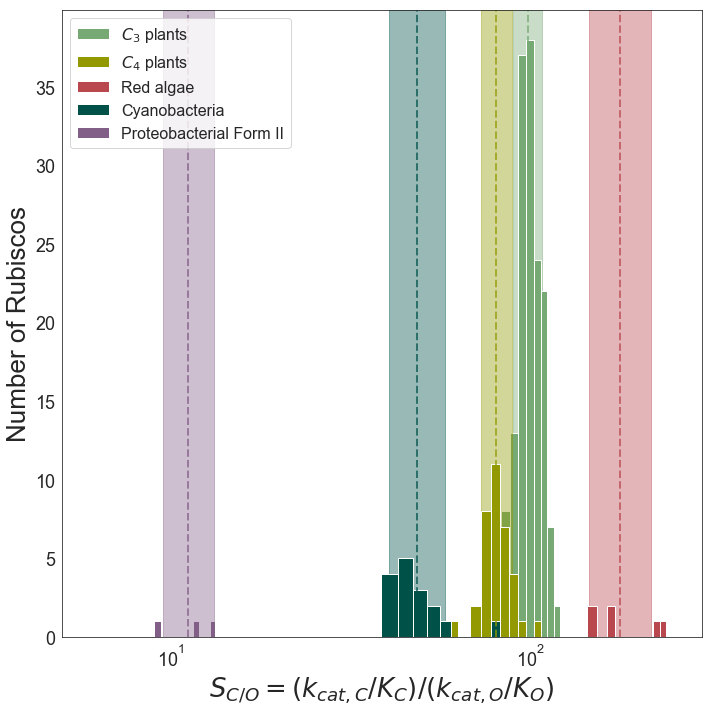

In [6]:
# Plot same as above, bigger format for talks/presentations
figure = plt.figure(figsize=(10,10))
sns.set_style('white')
plt.xscale('log')

for i, group in enumerate(plotting_order):
    if group.startswith('Other'):
        # skipping 'Other FI' here.
        continue
        
    gdf = grouped_taxa.get_group(group)
    cname = color_mapping[group]
    c = sns.xkcd_rgb[cname]
    
    # Plot geometric mean and std
    mask = gdf.S.notnull()
    masked_S = gdf[mask].S
    gmean_S = stats.gmean(masked_S)
    gstd = np.exp(np.nanstd(np.log(masked_S)))
    plt.axvline(gmean_S, color=c, ls='--', alpha=0.7, lw=2)
    plt.axvspan(gmean_S/gstd, gmean_S*gstd, color=c, alpha=0.4)
    
    # Plot hist above stats. 
    label = fancy_labels.get(group, group)
    plt.hist(gdf.S, color=c, label=label)
    

cname = 'dusty purple'
c = sns.xkcd_rgb[cname]
plt.hist(F2_data.S, color=c, label='Proteobacterial Form II')

mask = F2_data.S.notnull()
masked_S = F2_data[mask].S
gmean_S = stats.gmean(masked_S)
gstd = np.exp(np.nanstd(np.log(masked_S)))
plt.axvline(gmean_S, color=c, ls='--', alpha=0.7, lw=2)
plt.axvspan(gmean_S/gstd, gmean_S*gstd, color=c, alpha=0.4)
    
plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlabel('$S_{C/O} = ( k_{cat,C}/K_C ) / ( k_{cat,O}/K_O )$', fontsize=26)
plt.ylabel('Number of Rubiscos', fontsize=26)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlim(5e0, 3e2)
plt.tight_layout()

plt.show()

In [7]:
# Regress on F1 data to get best fit. 
kon_Os = np.log(F1_data.kon_O)
kon_Cs = np.log(F1_data.kon_C)

exp_F1, pre_F1, r_F1 = power_laws.fit_power_law_odr(kon_Os, kon_Cs, unit_exp=False)
print('kcat,C/KC = %.2f * (kcat,O/KO)^(%.2f), R = %.3g' % (pre_F1, exp_F1, r_F1))

kcat,C/KC = 118.93 * (kcat,O/KO)^(1.04), R = 0.943


In [8]:
# Bootstrapped regression over the FI rubiscos. Need to hardcode this because we are inferring
# kcat,C/KC and kcat,O/KO values in the inner loop by sampling from measured parameters. 

# konC = vC/KC (both measured)
# konO = vO/KO (vO not measured)
# S = vC/KC / (vO/KO)
# Therefore,
# vO = vC/KC / (S/KO) and
# konO = vC/KC / (S/KO) / (KO) = vC/(S KC)

all_FIs = merged_kin_df[merged_kin_df.isoform == '1']
fraction = 0.9
tot = all_FIs.kon_C.size
subset_size = int(fraction * tot)

runs = 10000
exponents = []
prefactors = []
prefactors_1 = []
rvals = []
for _ in range(runs):
    idxs = np.random.choice(tot, subset_size)
    subset = all_FIs.iloc[idxs]
    
    # Make kcatC/KC sample
    vC_vals = subset.vC
    KC_vals = subset.KC
    konC_vals = vC_vals / KC_vals

    # kcatO/KO sample
    S_vals = subset.S
    konO_vals = vC_vals / KC_vals / S_vals
    
    log_konC = np.log(konC_vals)
    log_konO = np.log(konO_vals)
    
    # Fit a power law.
    exp, pre, rval = power_laws.fit_power_law_odr(log_konO, log_konC)
    exponents.append(exp)
    prefactors.append(pre)
    rvals.append(rval)
    
    # Fit a power law with exp = 1.0
    exp, pre, _ = power_laws.fit_power_law_odr(log_konO, log_konC, unit_exp=True)
    prefactors_1.append(pre)

Bootstrapping FI fits
95% CI for log-scale Pearson R (0.88, 0.95)
95% CI for power law exponent (0.93, 1.12)
95% CI on power law prefactor (63, 2e+02)
95% CI on power law prefactor (91, 97) assuming exp 1.0


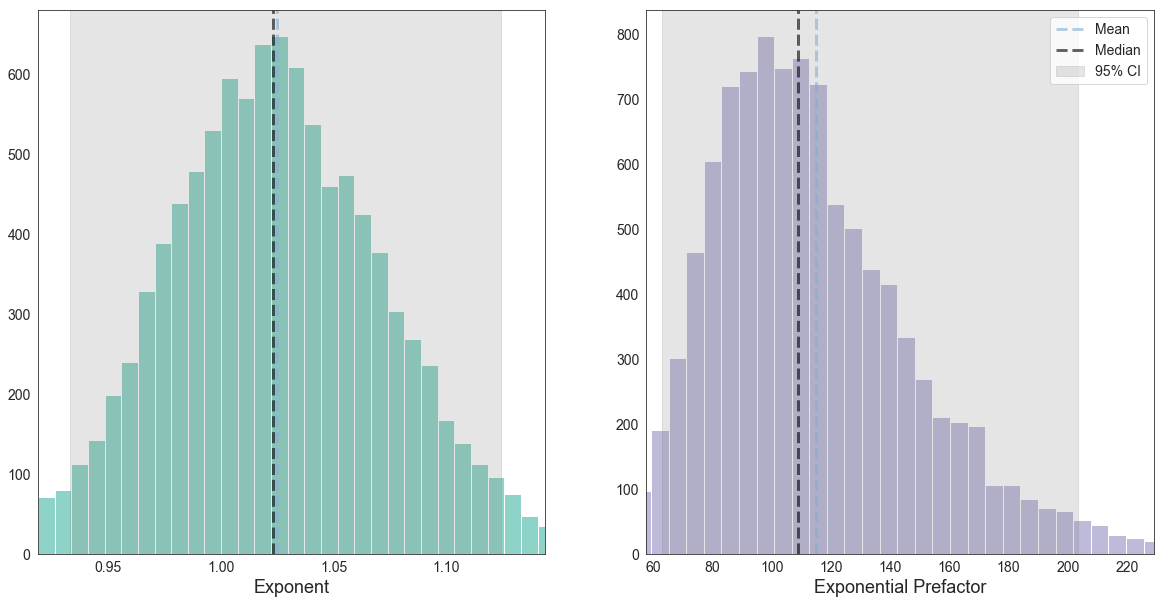

In [9]:
conf_range = [2.5, 97.5]
pre_low, pre_high = np.percentile(prefactors, conf_range)
exp_low, exp_high = np.percentile(exponents, conf_range)
r_low, r_high = np.percentile(rvals, conf_range)
pre1_low, pre1_high = np.percentile(prefactors_1, conf_range)

print('Bootstrapping FI fits')
print('95%% CI for log-scale Pearson R (%.2f, %.2f)' % (r_low, r_high))
print('95%% CI for power law exponent (%.2f, %.2f)' % (exp_low, exp_high))
print('95%% CI on power law prefactor (%.2g, %.2g)' % (pre_low, pre_high))
print('95%% CI on power law prefactor (%.2g, %.2g) assuming exp 1.0' % (pre1_low, pre1_high))

# Uncomment to look at the distributions. 
power_laws.plot_bootstrapped_range(exponents, prefactors)

In [10]:
# Regress on savir data to get previous fit. 
# NOTE: 1. Savir drops the FII Rubiscos for this fit, I think. Unclear from text if he dropped both or one.
# NOTE: 2. Can't reproduce his exponent of 0.5. I get 0.77. 
savir_FI = savir_df[savir_df.isoform == '1']

konOs = np.log(savir_FI.kon_O)
konCs = np.log(savir_FI.kon_C)
exp_savir, pre_savir, r = power_laws.fit_power_law_odr(konOs, konCs, unit_exp=False)
print(exp_savir, pre_savir, r)

1.2919820794135177 445.63818695938386 0.8396279800806695


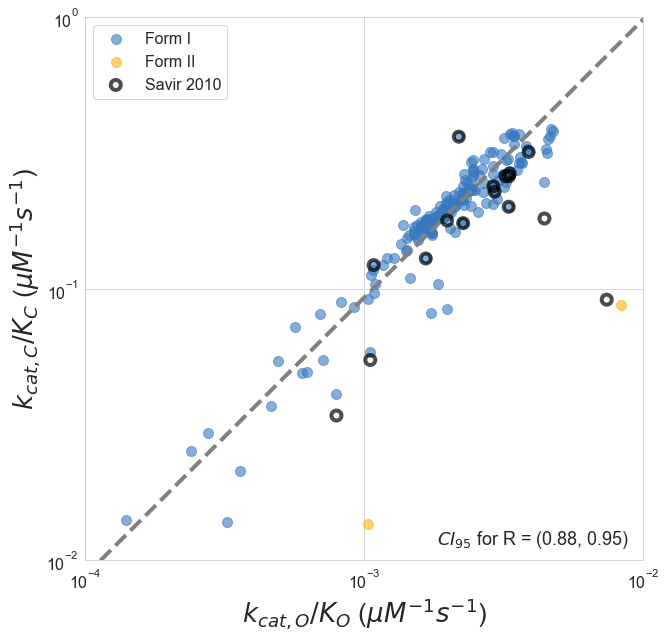

In [11]:
# Mechanistic proposal #2 from Savir - k_onC vs k_onO
figure = plt.figure(figsize=(10,10))
sns.set_style('whitegrid')
colors = sns.color_palette("BrBG", 10)

plt.xscale('log')
plt.yscale('log')

groups = {'1': 'I', 
          '2': 'II',
          '2_3': 'II/III', 
          '3': 'III'}

for i, (group, gdf) in enumerate(grouped_form):
    if group in ['3', '2_3']:
        continue
    label = 'Form %s' % groups[group]
    c = matplotlib.colors.rgb2hex(named_colors[i])
    plt.scatter(gdf.kon_O, gdf.kon_C,  c=c, s=100, label=label, alpha=0.6)

# Plot bootstrapped regression against FI data
xs = np.arange(1e-4, 2e-2, 0.01)
med_exp = np.median(exponents)
med_pre = np.median(prefactors)
ys = np.power(xs, med_exp)*med_pre
plt.plot(xs, ys, color='grey', ls='--', lw=4)

# Savir power law, inferred
#plt.plot(xs, np.power(xs, exp_savir)*pre_savir, c='grey', lw=2, ls='--')

# Show savir data with an outline
plt.scatter(savir_df.kon_O, savir_df.kon_C, c='None', edgecolors='k',
            linewidths=4, s=100, label='Savir 2010', alpha=0.7, zorder=10)
plt.text(0.63, 0.03, '$CI_{95}$ for R = (%.2f, %.2f)' % (r_low, r_high), 
         transform=figure.axes[0].transAxes, fontsize=18)

plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlabel('$k_{cat,O} / K_O$ ($\mu M^{-1} s^{-1}$)', fontsize=26)
plt.ylabel('$k_{cat,C} / K_C$ ($\mu M^{-1} s^{-1}$)', fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(1e-4, 1e-2)
plt.ylim(1e-2, 1)

plt.savefig('fig7/fig7_konC_konO_FI.png', dpi=600)

plt.show()

C3 plants
geomean S: 98.254
pred R2: 0.844

C4 plants
geomean S: 80.416
pred R2: 0.960

Cyanobacteria
geomean S: 48.323
pred R2: 0.788

Other Form I
geomean S: 81.030
pred R2: 0.882



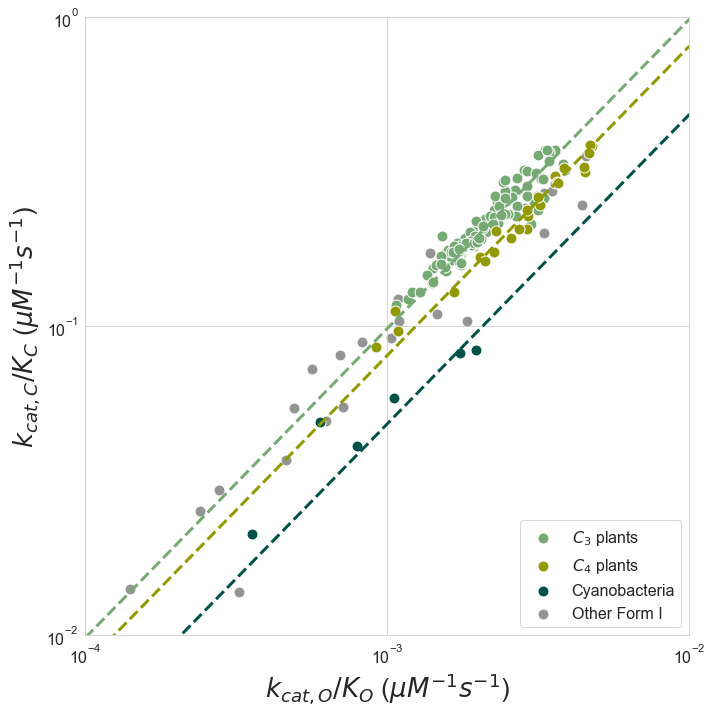

In [12]:
# Mechanistic proposal #1 from Savir - kcat,C/KC vs kcat,C color by isoform
figure = plt.figure(figsize=(10,10))
sns.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

plotting_order_subset = ['C3 plants', 'C4 plants', 'Cyanobacteria', 'Other Form I']

def plot_group(group, gdf, color, label, z=None, plot_trend=True):
    # Scatter plot of the data
    plt.scatter(gdf.kon_O, gdf.kon_C, c=[c], s=120, label=label, edgecolors='w',
                zorder=z)
    
    # Plot trend line if asked.
    if not plot_trend:
        return
    
    # No need for regression here - log10(S) is the y-intercept for each group
    mask = gdf.S.notnull()
    masked_S = gdf[mask].S
    gmean_S = stats.gmean(masked_S)
    xs = np.logspace(-4, -2, 100)
    pred_ys = xs * gmean_S
    plt.plot(xs, pred_ys, ls='--', lw=3, color=c)
    
    
for group in plotting_order_subset:
    cname = color_mapping[group]
    gdf = grouped_taxa.get_group(group)
    
    label = fancy_labels.get(group, group)
    c = sns.xkcd_rgb[cname]
    
    # "Other FI" is not a coherent group, so it goes on the bottom 
    # and we don't plot the trend 
    z = -10 if group.startswith('Other') else None
    plot_trend = False if group.startswith('Other') else True
    
    plot_group(group, gdf, c, label, z, plot_trend)
    
    # Calculate quality of "regression" as R2 on the pred. and actual Y vals
    gmean_S = stats.gmean(gdf[gdf.S.notnull()].S)
    mask = gdf.kon_C.notnull() & gdf.kon_O.notnull()
    actual_ys = gdf[mask].kon_C
    pred_ys = gdf[mask].kon_O * gmean_S
    print(group)
    print('geomean S: %.3f' % gmean_S)
    print('pred R2: %.3f' % metrics.r2_score(actual_ys, pred_ys))
    print()

plt.legend(loc=4, fontsize=16, frameon=True)
plt.xlabel('$k_{cat,O} / K_O$ ($\mu M^{-1} s^{-1}$)', fontsize=26)
plt.ylabel('$k_{cat,C} / K_C$ ($\mu M^{-1} s^{-1}$)', fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(1e-4, 1e-2)
plt.ylim(1e-2, 1)
plt.tight_layout()

plt.savefig('fig7/fig7_konC_konO_FI_by_group.png', dpi=600)
plt.show()

In [13]:
# Claim: overall fit is about as good when we force the power law exponent 1.0
# Evaluate the claim by testing the R2 of predicted kcat,C/KC values in both scenarios.
# First scenario: power-law fit with two free parameters - prefactor and exp.
# Second: assume exp = 1.0 and prefactor is geometric mean of SC/O values. 
# Because TLS fits don't maximize R2 of Y value predictions, also test a third scenario
# where we use ordinary linear regression. 
mask = F1_data.kon_O.notnull() & F1_data.kon_C.notnull()
konOs = F1_data[mask].kon_O
konCs = F1_data[mask].kon_C
log_konOs = np.log(konOs)
log_konCs = np.log(konCs)
print('Exponent as free parameter, TLS fit')
exp, pre, r = power_laws.fit_power_law_odr(log_konOs, log_konCs, unit_exp=False)
pred_konOs = np.power(konCs/pre, 1/exp)
r2_val = metrics.r2_score(konOs, pred_konOs)
print('kcat,C/KC = %.2f (kcat,O/KO)^(%.2f)' % (pre, exp))
print('pred R2: %.3f' % r2_val)
print()

print('Force exponent=1.0 using geometric mean SC/O as prefactor')
Ss = F1_data[F1_data.S.notnull()].S
gmean_S = stats.gmean(Ss)
pred_konOs = konCs/gmean_S
r2_val = metrics.r2_score(konOs, pred_konOs)
print('kcat,C/KC = %.2f (kcat,O/KO)' % gmean_S)
print('pred R2: %.3f' % r2_val)
print()

print('Exponent as free parameter, OLS fit')
exp, pre, r, p, se = power_laws.fit_power_law(log_konOs, log_konCs)
pred_konOs = np.power(konCs/pre, 1/exp)
r2_val = metrics.r2_score(konOs, pred_konOs)
print('kcat,C/KC = %.2f (kcat,O/KO)^(%.2f)' % (pre, exp))
print('pred R2: %.3f' % r2_val)
print()

# Notice that the R2 values are comparable in all cases at 0.75-0.8

Exponent as free parameter, TLS fit
kcat,C/KC = 118.93 (kcat,O/KO)^(1.04)
pred R2: 0.815

Force exponent=1.0 using geometric mean SC/O as prefactor
kcat,C/KC = 89.97 (kcat,O/KO)
pred R2: 0.804

Exponent as free parameter, OLS fit
kcat,C/KC = 81.05 (kcat,O/KO)^(0.98)
pred R2: 0.814



In [14]:
# Bootstrapped confidence intervals for each group. 
for i, (group, gdf) in enumerate(grouped_taxa): 
    if group.startswith('Other'):
        continue

    # Only use points that have data - bootstrapping will work right now.
    mask = gdf.kon_O.notnull() & gdf.kon_C.notnull()
    size = mask.sum()
    masked_gdf = gdf[mask]
    
    print(group)
    print('%d data points' % size)
    if size < 6:
        print('Not enough data')
        print()
        continue
        
    exps, pres, rs = power_laws.bootstrap_power_law_odr(
        masked_gdf.kon_O, masked_gdf.kon_C, rounds=1000)
    
    ci = 0.95
    ci_end = (1.0 - ci)/2.0
    conf_range = [100-100*ci_end, 100*ci_end]
    pre_interval = np.percentile(pres, conf_range)
    exp_interval = np.percentile(exps, conf_range)
    rs_interval = np.percentile(rs, conf_range)
    
    print('exponent 95% ci:', exp_interval)
    print('prefactor 95% ci:', pre_interval)
    print('pearson R 95% ci:', rs_interval)
    print()

C3 plants
120 data points
exponent 95% ci: [1.00614183 0.86698079]
prefactor 95% ci: [105.38368258  44.04541769]
pearson R 95% ci: [0.96543179 0.91791168]

C4 plants
24 data points
exponent 95% ci: [1.0142288  0.82951444]
prefactor 95% ci: [85.56316725 29.17095864]
pearson R 95% ci: [0.99380176 0.97062266]

Cyanobacteria
6 data points
exponent 95% ci: [1.0625863  0.45353428]
prefactor 95% ci: [100.98879325   1.4135017 ]
pearson R 95% ci: [1.         0.79780847]

Red algae
1 data points
Not enough data



In [15]:
sorted_konC = grouped_taxa.get_group('C3 plants').sort_values('kon_C', ascending=False)
mask = sorted_konC.kon_C.notnull() & sorted_konC.kon_O.notnull()
sorted_konC[mask]

,species,mutant,isoform,KC,vC,S,KO,KRuBP,vO,kon_C,kon_O
taxonomy,,,,,,,,,,,
C3 plants,Limonium magallufianum,0,1,7.00,2.600,108.50,297.0,NaN,0.997,0.3720,0.00337
C3 plants,Limonium companyonis,0,1,8.90,3.300,112.00,429.0,NaN,1.420,0.3710,0.00332
C3 plants,Limonium balearicum,0,1,9.70,3.600,103.00,346.0,NaN,1.240,0.3710,0.00359
C3 plants,Limonium echioides,0,1,10.70,3.900,106.00,427.0,NaN,1.460,0.3650,0.00343
C3 plants,Limonium barceloi,0,1,9.30,3.400,106.00,346.0,NaN,1.190,0.3650,0.00344
C3 plants,Limonium grosii,0,1,8.10,2.900,113.00,328.0,NaN,1.040,0.3580,0.00316
C3 plants,Nicotiana tabacum L. cv. W38,0,1,11.05,3.585,99.75,269.5,NaN,0.890,0.3405,0.00343
C3 plants,Panicum bisulcatum,0,1,7.80,2.600,87.70,416.0,NaN,1.570,0.3340,0.00380
C3 plants,Nicotiana tabacum,0,1,9.70,3.300,86.90,292.0,18.9,1.140,0.3195,0.00388
